## 18.1 Understanding the capstone project

Forecasting electric energy consumption is a common task with worldwide applications. In developing countries, it can help in planning the construction of power grids. In countries where the grid is already developed, forecasting energy consumption ensures that the grid can provide enough energy to power all households efficiently.

With accurate forecasting models, energy companies can better plan the load on the grid, ensuring that they are producing enough energy during peak times or have sufficient energy reserves to meet the demand. Also, they can avoid producing too much electricity, which, if it’s not stored, could cause an imbalance in the grid, posing a risk of disconnection. Thus, forecasting electric energy consumption is an important problem that has consequences in our daily lives.

### 18.1.1 Objective of this capstone project

The objective of this capstone project is to create a model that can forecast the next 24 hours of global active power. If you feel confident, this objective should be sufficient for you to download the dataset, work it on your own, and compare your process
to the one presented in this chapter.

Otherwise, here are the steps that need to be done:

1. Data wrangling and preprocessing. This step is optional. It is not directly linked to time series forecasting, but it is an important step in any machinelearning project. You can safely skip this step and start at step 2 with a clean dataset:
    1. Calculate the number of missing values.
    2. Impute the missing values.
    3. Express each variable as a numerical value (all data is originally stored as strings).
    4. Combine the Date and Time columns into a DateTime object.
    5. Determine whether the data sampled at every minute is usable for forecasting.
    6. Resample the data by hour.
    7. Remove any incomplete hours.
2. Feature engineering:
    1. Identify any seasonality.
    2. Encode the time with a sine and cosine transformation.
    3. Scale the data.
3. Split the data:
    1. Make a 70:20:10 split to create training, validation, and test sets.
4. Prepare for deep learning modeling:
    1. Implement the DataWindow class.
    2. Define the compile_and_fit function.
    3. Create a dictionary of column indices and column names.
5. Model with deep learning:
    1. Train at least one baseline model.
    2. Train a linear model.
    3. Train a deep neural network.
    4. Train an LSTM.
    5. Train a CNN.
    6. Train a combination of LSTM and CNN.
    7. Train an autoregressive LSTM.
    8. Select the best-performing model.
    
You now have all the steps required to successfully complete this capstone project. I highly recommend that you try it on your own first, as that will reveal what you have mastered and what you need to review. At any point, you can refer to the following sections
for a detailed walkthrough of each step.

## 18.2 Data wrangling and preprocessing

Data wrangling is the process of transforming data into a form that is easily usable for modeling. This step usually involves exploring missing data, filling in blank values, and ensuring that the data has the right type, meaning that numbers are numerical values and not strings. This is a complex step, and it’s probably the most vital one in any machine learning project. Having poor quality data at the start of a forecasting project is a guarantee that you’ll have poor quality forecasts. You can skip this section of the chapter if you wish to focus solely on time series forecasting, but I highly recommend that you go through it, as it will really help you become comfortable with the dataset.

Start by importing libraries that will be useful for data manipulation and visualization

In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

2023-01-18 19:28:19.816380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 19:28:20.732840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 19:28:20.732875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 19:28:20.879951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-18 19:28:23.014675: W tensorflow/stream_executor/platform/de

Whenever numpy and TensorFlow are used, I like to set a random seed to ensure that the results can be reproduced. If you do not set a seed, your results might vary, and if you set a seed that’s different than mine, your results will differ from those shown here.

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

The next step is to read the data file into a DataFrame. We are working with a raw text file, but we can still use the read_csv method from pandas. We simply need to specify the separator, which is a semicolon in this case.

In [3]:
df = pd.read_csv('./household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 18.2.1 Dealing with missing data

Now let’s check for missing values. We can do this by chaining the isna() method with the sum() method. This returns the sum of missing values for each column of our dataset.

From the output shown in figure 18.2, only the Sub_metering_3 column has missing
values. In fact, about 1.25% of its values are missing, according to the documentation of the data.

In [4]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

There are two options we can explore for dealing with the missing values. First, we could simply delete this column, since no other features have missing values. Second, we could fill in the missing values with a certain value. This process is called imputing.

We’ll first check whether there are many consecutive missing values. If that is the case, it is preferable to get rid of the column, as imputing many consecutive values will likely introduce a nonexistent trend in our data. Otherwise, if the missing values are dispersed across time, it is reasonable to fill them. The following code block outputs the length of the longest sequence of consecutive missing values:

In [5]:
# Plot Sub_metering_3 to see if there is a noticeable gap in missing values. 
# Useful to see if there are a lot of consecutive 
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

This outputs a length of 7,226 consecutive minutes of missing data, which is equivalent to roughly 5 days. In this case, the gap is definitely too large to fill with missing values, so we’ll remove this column from the dataset.

In [6]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


### 18.2.2 Data conversion
Now let’s check if our data has the right type. We should be studying numerical data, as our dataset is a collection of sensor readings.

We can output the type of each column using df.dtypes, which shows us that each column is of object type. In pandas this means that our data is mostly text, or a mix of numeric and non-numeric values.

We can convert each column to a numerical value with the to_numeric function from pandas. This is essential, as our models expect numerical data. Note that we will not convert the date and time columns to numerical values—these will be processed in a later step.

In [7]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

18.2.3 Data resampling
The next step is to check if data sampled every minute is appropriate for modeling. It
is possible that data sampled every minute is too noisy to build a performant predictive
model.
To check this, we’ll simply plot our target to see what it looks like. The resulting
plot is shown in figure 18.3.We can optionally check the type of each column again using df.dtypes to make sure that the values were converted correctly. This will show that every column from Global_active_power to Sub_metering_2 is now a float64 as expected.

In [8]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

### 18.2.3 Data resampling

The next step is to check if data sampled every minute is appropriate for modeling. It is possible that data sampled every minute is too noisy to build a performant predictive model.

To check this, we’ll simply plot our target to see what it looks like. The resulting plot is shown in figure 18.3.

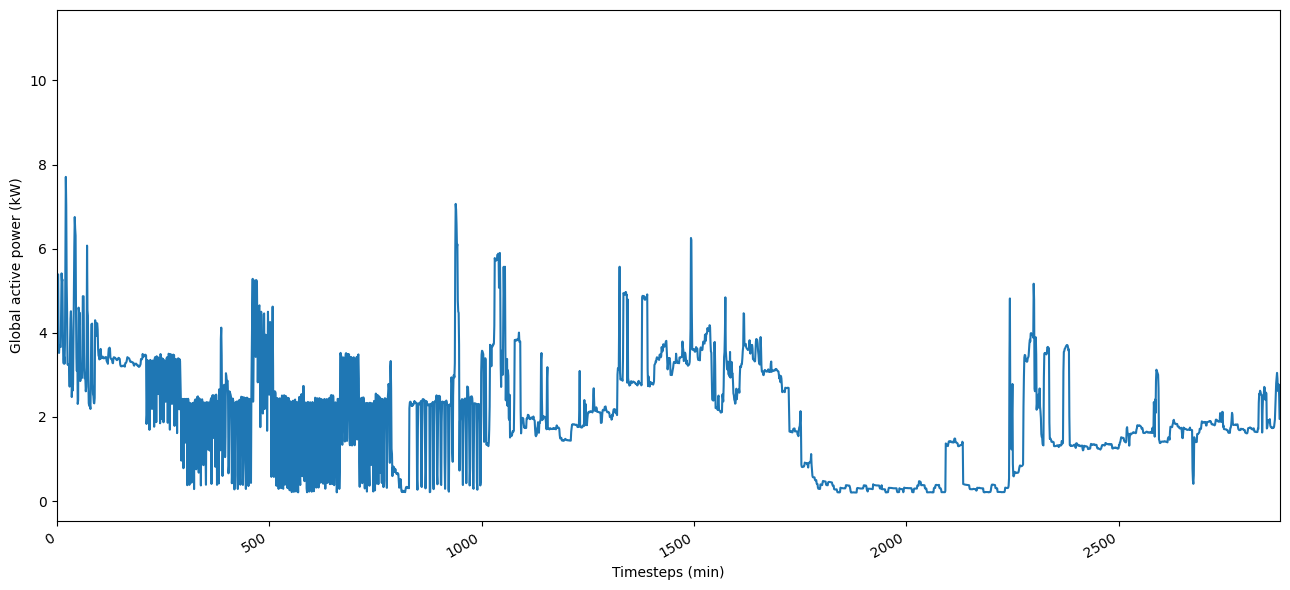

In [9]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

Figure 18.3 shows that the data is very noisy, with large oscillations or flat sequences occurring at every minute. This kind of pattern is difficult to forecast using a deep learning model, since it seems to move at random. Also, we could question the need to forecast electricity consumption by the minute, as changes to the grid cannot occur in such short amounts of time.

Thus, we definitely need to resample our data. In this case, we’ll resample by the hour. That way, we’ll hopefully smooth out the data and uncover a pattern that may be easier to predict with a machine learning model.

To do this, we’ll need a datetime data type. We can combine the Date and Time columns to create a new column that holds the same information with a datetime data type.

In [10]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


Now we can resample our data. In this case, we’ll take an hourly sum of each variable. That way we’ll know the total electrical power consumed by the household every hour.

In [11]:
hourly_df = df.resample('H', on='datetime').sum()

Remember that our data started on December 16, 2006, at 5:24 p.m. and ended on November 26, 2010, at 9:02 p.m. With the new resampling, we now have a sum of each column per hour, which means that we have data that starts on December 16, 2006, at 5 p.m. and ends on November 26, 2010, at 9 p.m. However, the first and last rows of data do not have a full 60 minutes in their sum. The first row computed the sum from 5:24 p.m. to 5:59 p.m., which is 35 minutes. The last row computed the sum from 9:00 p.m. to 9:02 p.m., which is only 2 minutes. Therefore, we’ll remove the first and last rows of data so that we are working only with sums over full hours.

In [12]:
hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)

Finally, this process has changed the index. I personally prefer to have the index as integers and the dates as a column, so we’ll simply reset the index of our DataFrame.

In [13]:
hourly_df = hourly_df.reset_index()

We can optionally check the shape of our data using hourly_df.shape, and we would see that we now have 34,949 rows of data. This is a drastic drop from the original two million rows. Nevertheless, a dataset of this size is definitely suitable for deep learning methods
.
Let’s plot our target again to see if resampling our data generated a discernible pattern that can be forecast. Here we’ll plot the first 15 days of global active power sampled hourly:

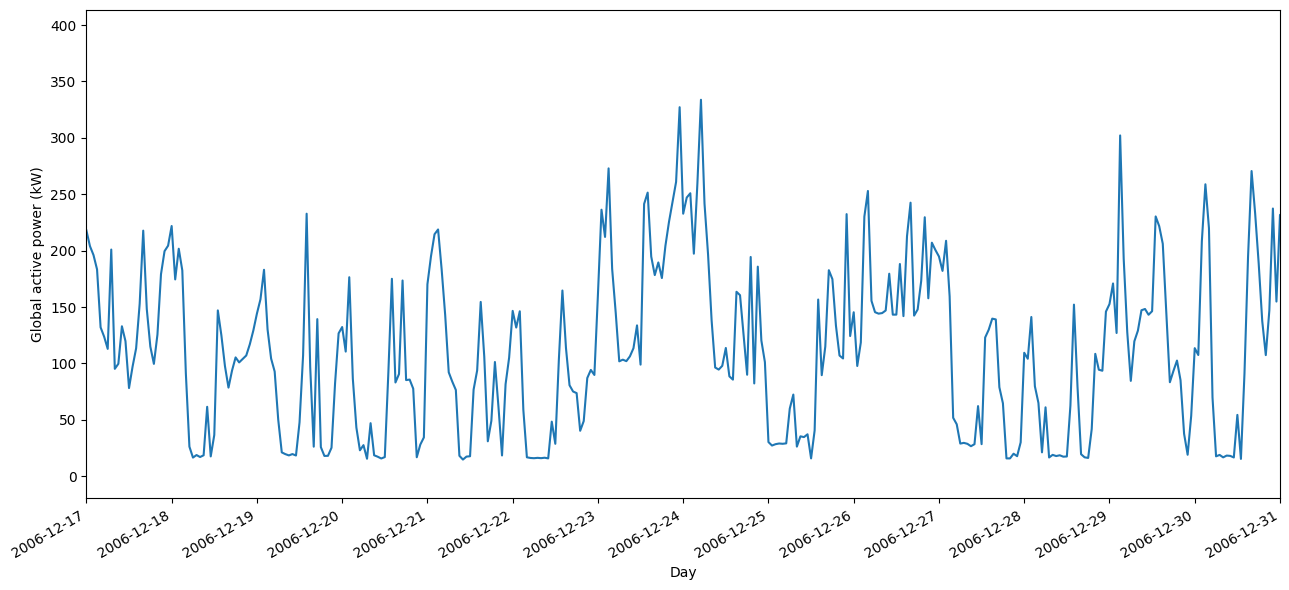

In [14]:
# Plot first 15 full days of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

As you can see in figure 18.4, we now have a smoother pattern of global active power. Furthermore, we can discern daily seasonality, although it is not as apparent as previous examples in this book.

With the data wrangling done, we can save our dataset as a CSV file so we have a clean version of our data. This will be our starting file for the next section.

In [15]:
hourly_df.to_csv('./clean_household_power_consumption.csv', header=True, index=False)

## 18.3 Feature engineering

At this point, we have a clean dataset with no missing values and a smoothed pattern that will be easier to predict using deep learning techniques. Whether you followed along with the last section or not, you can read a clean version of the data and start working on the feature engineering.

In [16]:
hourly_df = pd.read_csv('./clean_household_power_consumption.csv')

### 18.3.1 Removing unnecessary columns

The first step in feature engineering is to display the basic statistics for each column. This is especially useful for detecting whether there are any variables that do not vary greatly. Such variables should be removed, since if they are almost constant over time, they are not predictive of our target.

We can get a description of each column using the describe method from pandas:

In [17]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


As you can see in figure 18.5, Sub_metering_1 is likely not a good predictor for our target, since its constant value will not explain the variations in global active power. We can safely remove this column and keep the rest.

In [18]:
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)

### 18.3.2 Identifying the seasonal period

With our target being global active power in a household, it is likely that we’ll have some seasonality. We can expect that at night, less electrical power will be used. Similarly, there may be a peak in consumption when people come back from work during the week. Thus, it is reasonable to assume that there will be some seasonality in our target.

We can plot our target to see if we can visually detect the period.

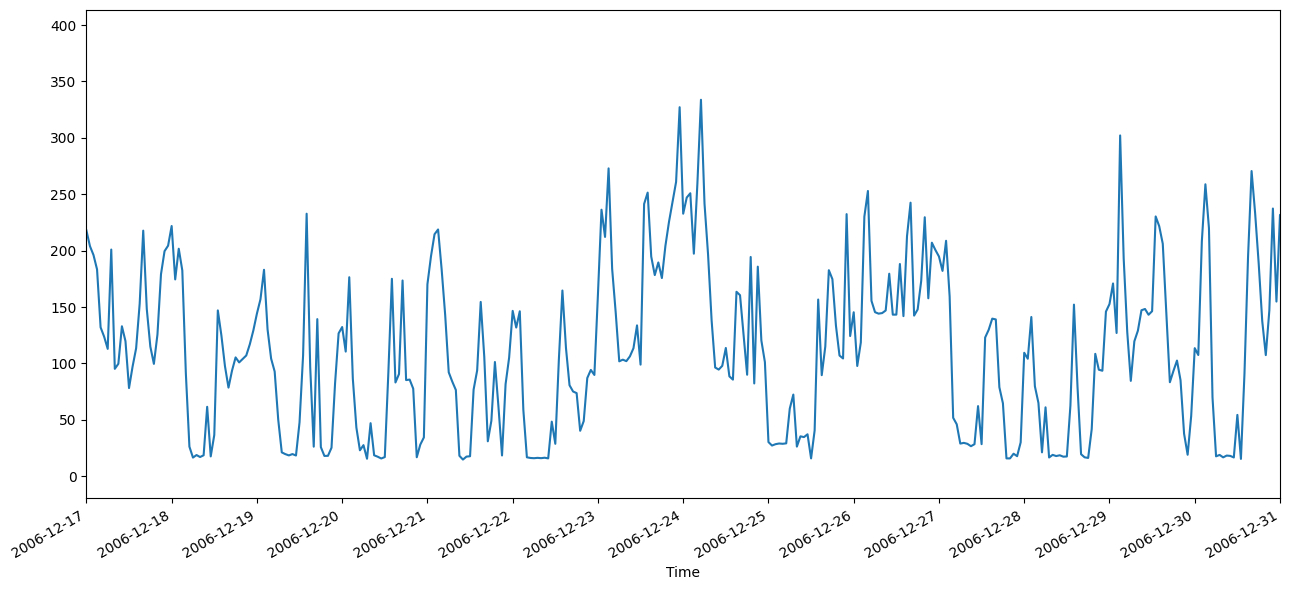

In [19]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Time')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

In figure 18.6 you can see that our target has some cyclical behavior, but the seasonal period is hard to determine from the graph. While our hypothesis about daily seasonality makes sense, we need to make sure that it is present in our data. One way to do it is with a Fourier transform.

Without diving into the details, a Fourier transform basically allows us to visualize the frequency and amplitude of a signal. Hence, we can treat our time series as a signal, apply a Fourier transform, and find the frequencies with large amplitudes. Those frequencies will determine the seasonal period. The great advantage of this method is that it is independent of the seasonal period. It can identify yearly, weekly, and daily seasonality, or any specific period we wish to test.

>For more information about Fourier transforms, I suggest reading Lakshay Akula’s “Analyzing seasonality with Fourier transforms using Python & SciPy” blog post, which does a great job of gently introducing Fourier transforms for analyzing seasonality: http://mng.bz/7y2Q. 

For our situation, let’s test for weekly and daily seasonality.

2023-01-18 19:33:56.186842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-18 19:33:56.187471: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-18 19:33:56.187519: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deedevelopment): /proc/driver/nvidia/version does not exist
2023-01-18 19:33:56.197359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


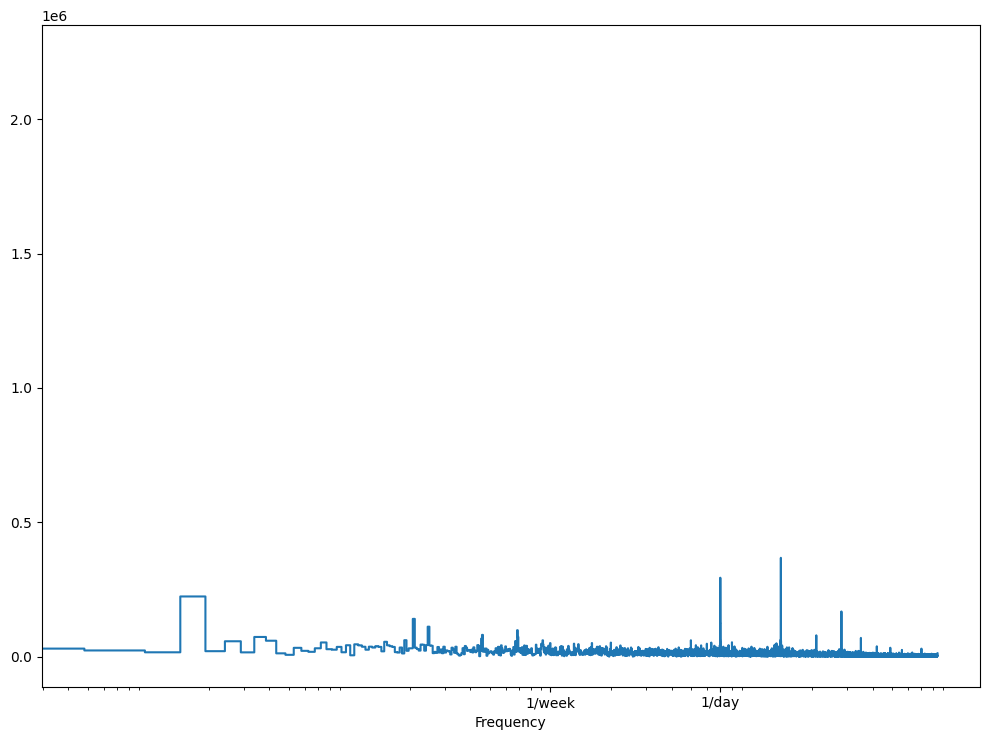

In [20]:
fft = tf.signal.rfft(hourly_df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(hourly_df['Global_active_power'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In figure 18.7 you can see the amplitude of the weekly and daily frequencies. The weekly frequency does not show any visible peak, meaning that its amplitude is very small. Therefore, there is no weekly seasonality.

Looking at the daily frequency, however, you’ll notice a clear peak in the figure. This tells us that we indeed have daily seasonality in our data. Thus, we will encode our timestamp using a sine and cosine transformation to express the time while keeping its daily seasonal information. We did the same thing in chapter 12 when preparing our data for modeling with deep learning.

In [21]:
timestamp_s = pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

hourly_df = hourly_df.drop(['datetime'], axis=1)

Our feature engineering is complete, and the data is ready to be scaled and split into training, validation, and test sets.

### 18.3.3 Splitting and scaling the data

The final step is to split the dataset into training, validation, and test sets, and to scale the data. Note that we’ll first split the data, so that we scale it using only the information from the training set, thus avoiding information leakage. Scaling the data will decrease training time and improve the performance of our models.

We’ll split the data 70:20:10 for the training, validation, and test sets respectively.

In [22]:
n = len(hourly_df)

# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24464, 7), (6990, 7), (3495, 7))

Next, we’ll fit the scaler to the training set only, and scale each individual set.

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

We can now save each set to be used later for modeling.

In [24]:
train_df.to_csv('./ch18_train.csv', index=False, header=True)
val_df.to_csv('./ch18_val.csv', index=False, header=True)
test_df.to_csv('./ch18_test.csv', index=False, header=True)

## 18.4 Preparing for modeling with deep learning

In the last section, we produced the three sets of data required for training deep learning models. Recall that the objective of this project is to predict the global active power consumption in the next 24 hours. This means that we must build a univariate multi-step model, since we are forecasting only one target 24 timesteps into the future.

We will build two baselines, a linear model, a deep neural network model, a long short-term memory (LSTM) model, a convolutional neural network (CNN), a combination of CNN and LSTM, and finally an autoregressive LSTM. In the end, we will use the mean absolute error (MAE) to determine which model is the best. The one that achieves the lowest MAE on the test set will be the top-performing model.

Note that we’ll use the MAE as our evaluation metric and the mean squared error (MSE) as the loss function, just as we have since chapter 13.

### 18.4.1 Initial setup

Before moving on to modeling, we first need to import the required libraries, as well as define our DataWindow class and a function to train our models.

We’ll start off by importing the necessary Python libraries for modeling.

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

Optionally, you can set parameters for the plots. In this case, I prefer to specify a size and remove the grid on the axes.

In [26]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

Then you can set a random seed. This ensures constant results when training models. Recall that the initialization of deep learning models is random, so training the same model twice in a row might result in slightly different performance. Thus, to ensure reproducibility, we set a random seed.

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

Next, we need to read the training set, validation set, and test set so they are ready for modeling.

In [28]:
train_df = pd.read_csv('./ch18_train.csv')
val_df = pd.read_csv('./ch18_val.csv')
test_df = pd.read_csv('./ch18_test.csv')

Finally, we’ll build a dictionary to store the column names and their corresponding indexes. This will be useful later on for building the baseline models and creating windows of data.

In [29]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

We’ll now move on to defining the DataWindow class.

In [30]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [31]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Model with deep learning

Creating single and multi window

### Training the baseline Models

In [32]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['Global_active_power']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['Global_active_power'])

In [33]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [34]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [35]:
val_performance = {}
performance = {}

val_performance['Baseline - Single'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Single'] = baseline_last.evaluate(single_step_window.test, verbose=0)


219/219 [==============================] - 1s 2ms/step - loss: 0.0101 - mean_absolute_error: 0.0651


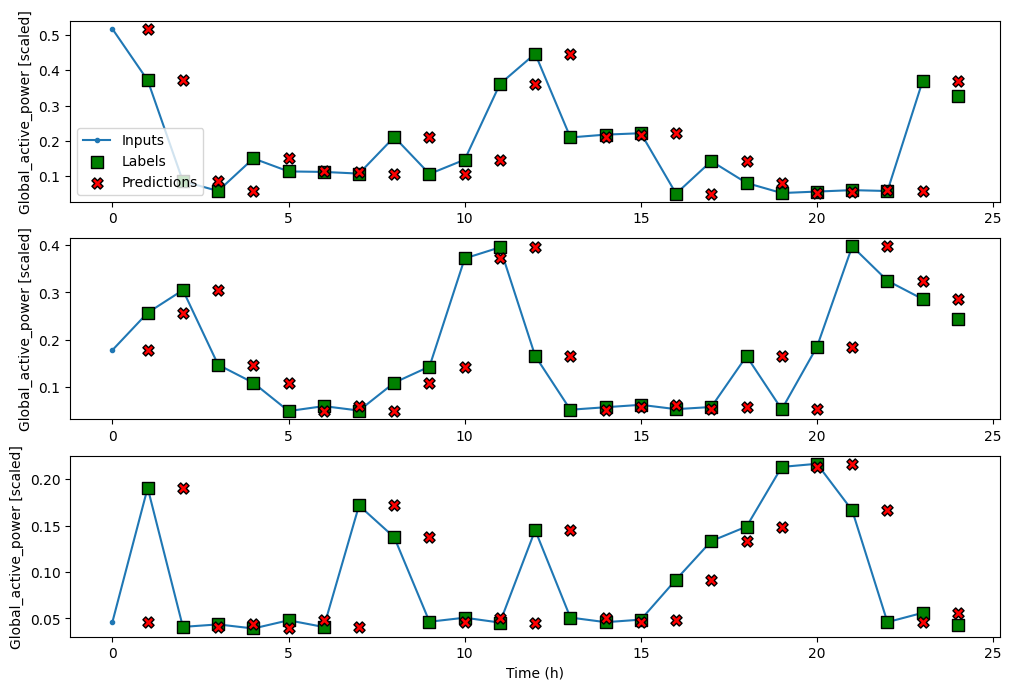

In [36]:
wide_window.plot(baseline_last)

In [37]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

#### Multistep Last Known Value

In [38]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [39]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 1s 3ms/step - loss: 0.1788 - mean_absolute_error: 0.3018


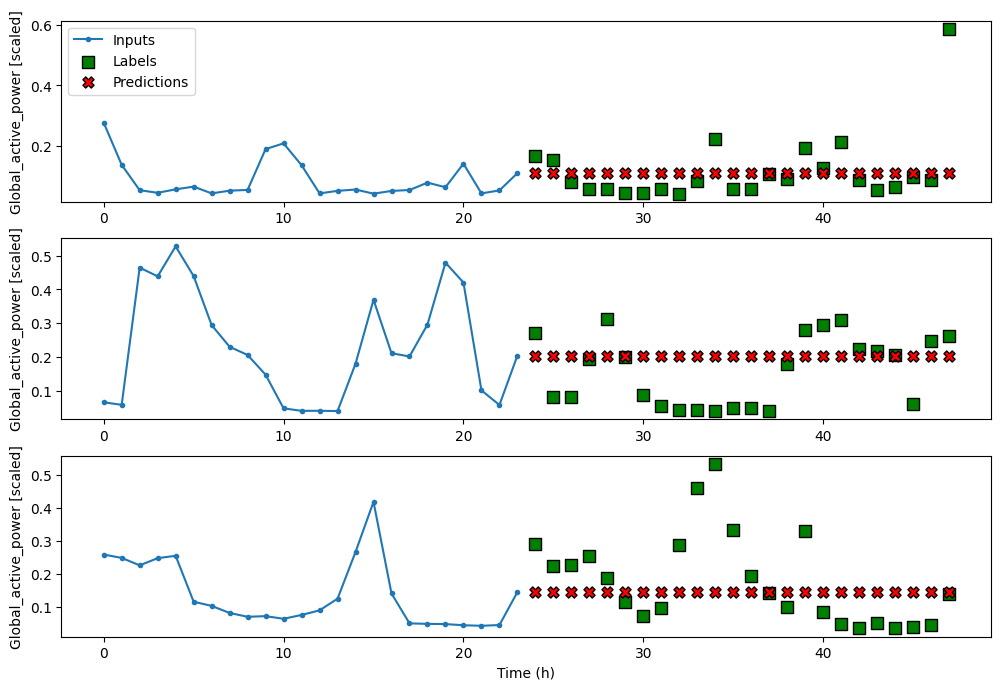

In [40]:
multi_window.plot(ms_baseline_last)

#### Multistep Last N Values (N = 24)

In [41]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

ms_baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 1s 3ms/step - loss: 0.1829 - mean_absolute_error: 0.3008


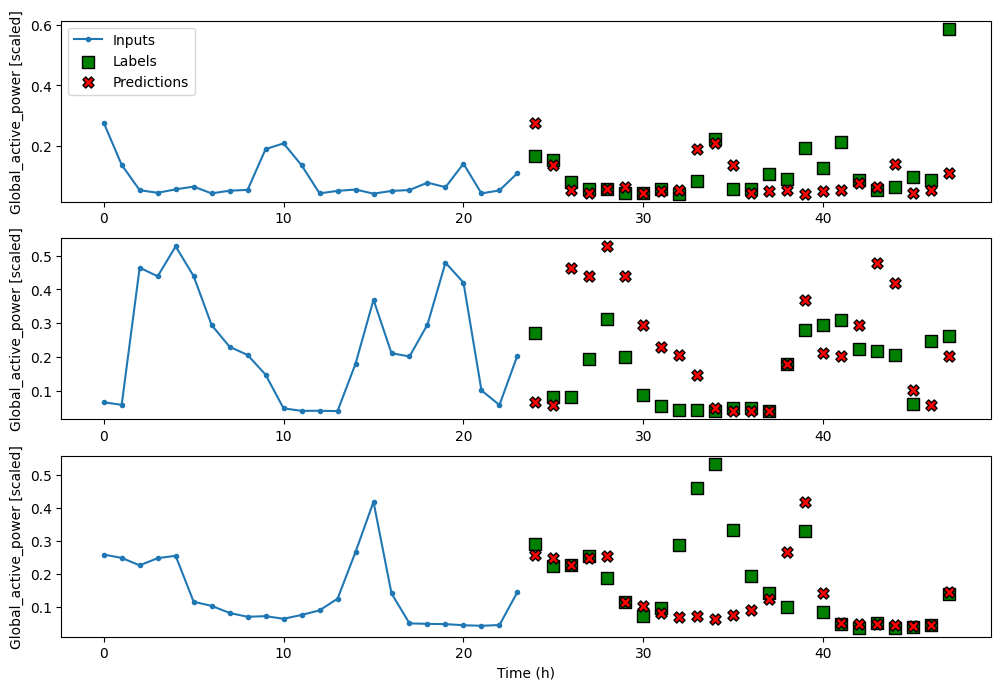

In [42]:
multi_window.plot(ms_baseline_repeat)

#### Baseline MAE Error Comparative

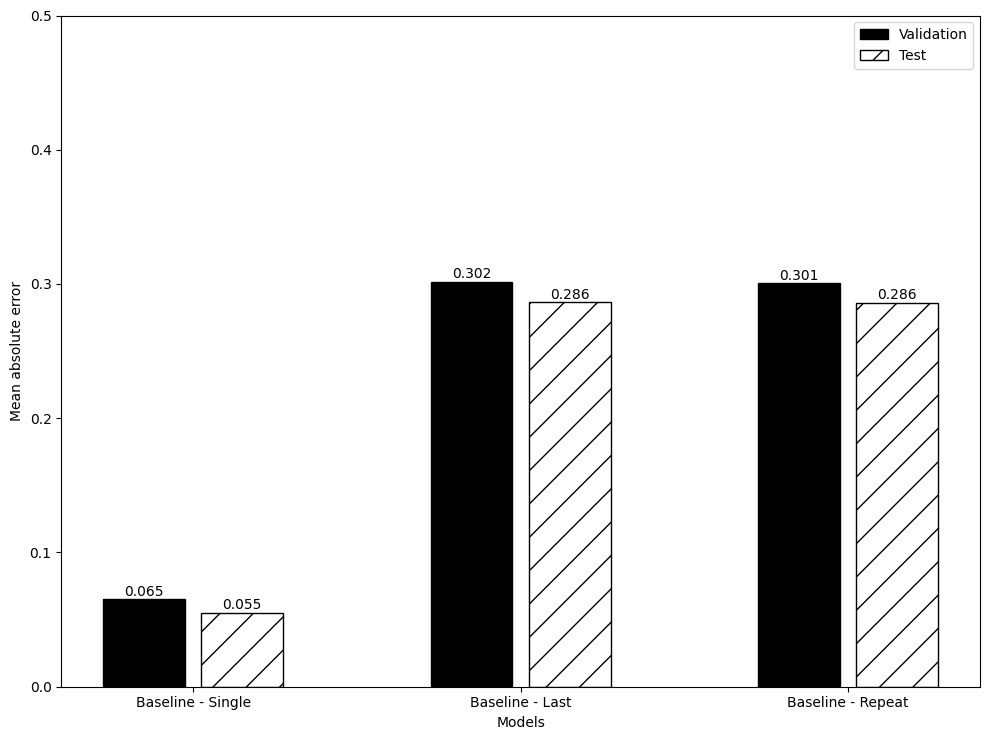

In [43]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

#### Training the linear models

In [44]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 3s 4ms/step - loss: 0.0179 - mean_absolute_error: 0.1035 - val_loss: 0.0143 - val_mean_absolute_error: 0.0933
Epoch 2/50
764/764 [==============================] - 3s 3ms/step - loss: 0.0162 - mean_absolute_error: 0.0976 - val_loss: 0.0142 - val_mean_absolute_error: 0.0921
Epoch 3/50
764/764 [==============================] - 3s 4ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0141 - val_mean_absolute_error: 0.0916
Epoch 4/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0141 - val_mean_absolute_error: 0.0916
Epoch 5/50
764/764 [==============================] - 3s 3ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0140 - val_mean_absolute_error: 0.0912
Epoch 6/50
764/764 [==============================] - 2s 3ms/step - loss: 0.0161 - mean_absolute_error: 0.0973 - val_loss: 0.0141 - val_mean_absolute_error: 0.0920
Epoch 7/50
764/7

#### Training a deep neural network

In [45]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense - Single'] = dense.evaluate(single_step_window.val)
performance['Dense - Single'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
765/765 [==============================] - 4s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0666 - val_loss: 0.0078 - val_mean_absolute_error: 0.0646
Epoch 2/50
765/765 [==============================] - 3s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0635 - val_loss: 0.0072 - val_mean_absolute_error: 0.0581
Epoch 3/50
765/765 [==============================] - 3s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0625 - val_loss: 0.0070 - val_mean_absolute_error: 0.0575
Epoch 4/50
765/765 [==============================] - 3s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0624 - val_loss: 0.0075 - val_mean_absolute_error: 0.0606
Epoch 5/50
765/765 [==============================] - 3s 4ms/step - loss: 0.0080 - mean_absolute_error: 0.0619 - val_loss: 0.0071 - val_mean_absolute_error: 0.0575
Epoch 6/50
219/219 [==============================] - 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0582


In [46]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

val_performance['Dense - Multi'] = ms_dense.evaluate(multi_window.val)
performance['Dense - Multi'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 5s 5ms/step - loss: 0.0154 - mean_absolute_error: 0.0924 - val_loss: 0.0126 - val_mean_absolute_error: 0.0818
Epoch 2/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.0887 - val_loss: 0.0127 - val_mean_absolute_error: 0.0815
Epoch 3/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0884 - val_loss: 0.0126 - val_mean_absolute_error: 0.0823
Epoch 4/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0882 - val_loss: 0.0127 - val_mean_absolute_error: 0.0829
Epoch 5/50
764/764 [==============================] - 3s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.0880 - val_loss: 0.0126 - val_mean_absolute_error: 0.0828
Epoch 6/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.0878 - val_loss: 0.0126 - val_mean_absolute_error: 0.0819
Epoch 7/50
764/7

#### Training an LSTM

In [47]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

val_performance['LSTM - Multi'] = ms_lstm_model.evaluate(multi_window.val)
performance['LSTM - Multi'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 17s 18ms/step - loss: 0.0165 - mean_absolute_error: 0.0968 - val_loss: 0.0131 - val_mean_absolute_error: 0.0873
Epoch 2/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0145 - mean_absolute_error: 0.0893 - val_loss: 0.0127 - val_mean_absolute_error: 0.0828
Epoch 3/50
764/764 [==============================] - 12s 16ms/step - loss: 0.0143 - mean_absolute_error: 0.0883 - val_loss: 0.0125 - val_mean_absolute_error: 0.0832
Epoch 4/50
764/764 [==============================] - 14s 18ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0126 - val_mean_absolute_error: 0.0833
Epoch 5/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0142 - mean_absolute_error: 0.0877 - val_loss: 0.0125 - val_mean_absolute_error: 0.0826
Epoch 6/50
764/764 [==============================] - 13s 17ms/step - loss: 0.0141 - mean_absolute_error: 0.0875 - val_loss: 0.0127 - val_mean_absolute_error: 0.0843
Epoc

#### Training a CNN 

In [48]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [49]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

val_performance['CNN - Multi'] = ms_cnn_model.evaluate(multi_window.val)
performance['CNN - Multi'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 5s 5ms/step - loss: 0.0154 - mean_absolute_error: 0.0926 - val_loss: 0.0127 - val_mean_absolute_error: 0.0833
Epoch 2/50
763/763 [==============================] - 3s 4ms/step - loss: 0.0143 - mean_absolute_error: 0.0881 - val_loss: 0.0127 - val_mean_absolute_error: 0.0820
Epoch 3/50
763/763 [==============================] - 4s 5ms/step - loss: 0.0142 - mean_absolute_error: 0.0876 - val_loss: 0.0127 - val_mean_absolute_error: 0.0821
Epoch 4/50
763/763 [==============================] - 3s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0875 - val_loss: 0.0127 - val_mean_absolute_error: 0.0827
Epoch 5/50
763/763 [==============================] - 3s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0873 - val_loss: 0.0127 - val_mean_absolute_error: 0.0835
Epoch 6/50
763/763 [==============================] - 3s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0872 - val_loss: 0.0127 - val_mean_absolute_error: 0.0825
Epoch 7/50
763/7

#### Training a LSTM + CNN

In [50]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

val_performance['CNN + LSTM Multi'] = ms_cnn_lstm_model.evaluate(multi_window.val)
performance['CNN + LSTM Multi'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 18s 19ms/step - loss: 0.0160 - mean_absolute_error: 0.0941 - val_loss: 0.0127 - val_mean_absolute_error: 0.0829
Epoch 2/50
763/763 [==============================] - 14s 18ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0125 - val_mean_absolute_error: 0.0836
Epoch 3/50
763/763 [==============================] - 14s 18ms/step - loss: 0.0141 - mean_absolute_error: 0.0871 - val_loss: 0.0126 - val_mean_absolute_error: 0.0810
Epoch 4/50
763/763 [==============================] - 14s 18ms/step - loss: 0.0140 - mean_absolute_error: 0.0868 - val_loss: 0.0126 - val_mean_absolute_error: 0.0813
Epoch 5/50
217/217 [==============================] - 2s 7ms/step - loss: 0.0125 - mean_absolute_error: 0.0813


Training an AR - LSTM

In [51]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [52]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 27s 25ms/step - loss: 0.0175 - mean_absolute_error: 0.1028 - val_loss: 0.0131 - val_mean_absolute_error: 0.0867
Epoch 2/50
763/763 [==============================] - 18s 23ms/step - loss: 0.0139 - mean_absolute_error: 0.0868 - val_loss: 0.0124 - val_mean_absolute_error: 0.0837
Epoch 3/50
763/763 [==============================] - 18s 23ms/step - loss: 0.0137 - mean_absolute_error: 0.0856 - val_loss: 0.0121 - val_mean_absolute_error: 0.0823
Epoch 4/50
763/763 [==============================] - 18s 23ms/step - loss: 0.0135 - mean_absolute_error: 0.0851 - val_loss: 0.0120 - val_mean_absolute_error: 0.0806
Epoch 5/50
763/763 [==============================] - 17s 23ms/step - loss: 0.0135 - mean_absolute_error: 0.0848 - val_loss: 0.0120 - val_mean_absolute_error: 0.0816
Epoch 6/50
763/763 [==============================] - 17s 23ms/step - loss: 0.0134 - mean_absolute_error: 0.0846 - val_loss: 0.0126 - val_mean_absolute_error: 0.0813
Epoc

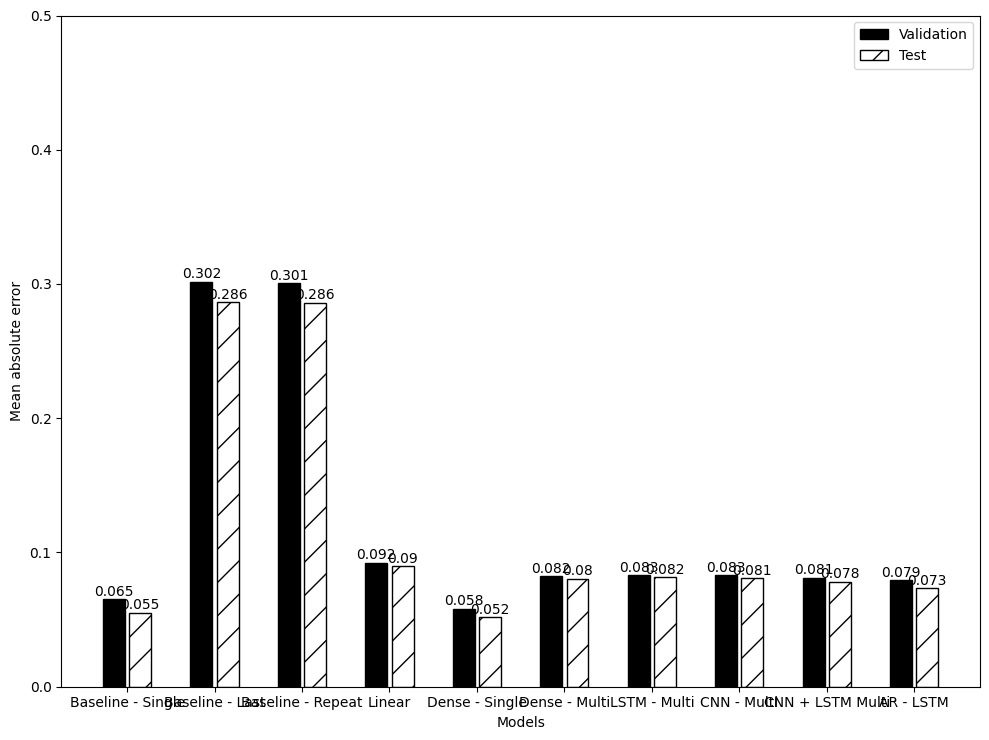

In [53]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

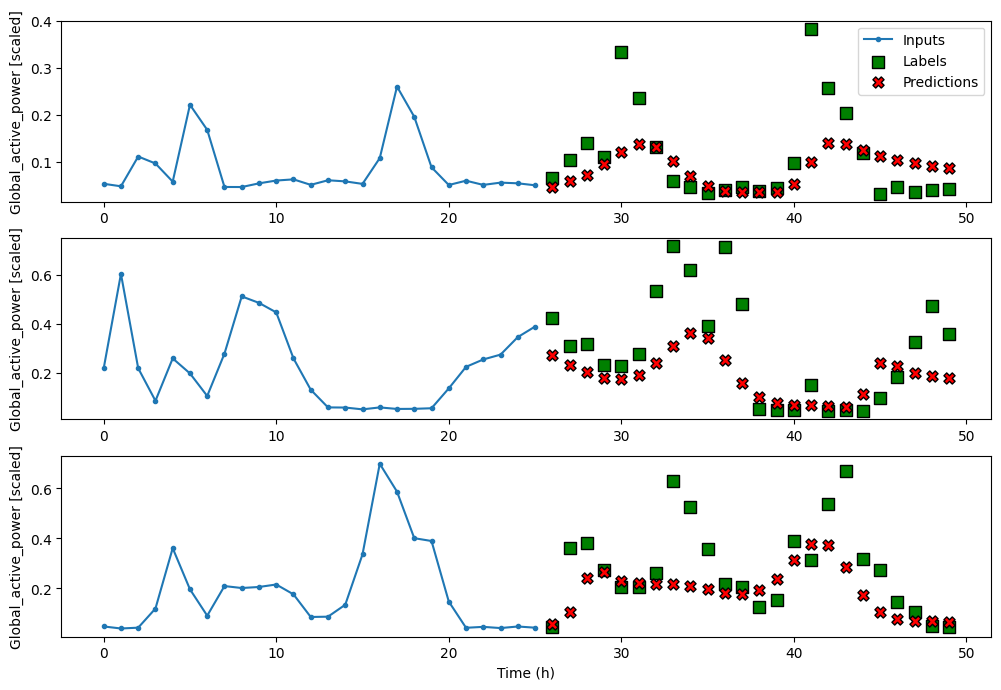

In [54]:
multi_window.plot(AR_LSTM)